In [1]:
import tensorflow as tf
import pandas as pd
import multiprocessing
import concurrent.futures
from PIL import Image
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from keras.applications import DenseNet201
from keras.models import Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [8]:
image_size=224
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((image_size,image_size)))
def get_images(df_paths):
    max_workers = multiprocessing.cpu_count()
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        image_arrays = list(executor.map(resize_image_array, ('ISIC_2020/train/' + df_paths['image_name'] + '.jpg').tolist()))
    return np.array(image_arrays)

In [3]:
def load_data(x_df_path, y_df_path):
    x_df = pd.read_csv(x_df_path)
    y_df = pd.read_csv(y_df_path)
    x_paths = x_df.iloc[:, 0:1]
    y = y_df.iloc[:,:].values
    x_img = get_images(x_paths)
    x_img = np.array(x_img)
    x_img = x_img / 255
    return x_img, y

In [4]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [2]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

def build_densenet201():
    base_model = DenseNet201(weights='imagenet',
                             include_top=False,
                             input_tensor=Input(shape=(224, 224, 3))
                            )
    
    for layer in base_model.layers:
        layer.trainable = True
    
    x = GlobalAveragePooling2D()(base_model.output)
    
    x = Dense(512)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(128)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(52)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(16)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(2, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    
    optimizer = Adam(learning_rate=0.0001)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [6]:
X_train, y_train = load_data('X_train_df.csv', 'y_train_df.csv')
X_val, y_val = load_data('X_val_df.csv', 'y_val_df.csv')

In [9]:
X_test, y_test = load_data('X_test_df.csv', 'y_test_df.csv')

In [7]:
batch_size = 4
train_gen = DataGenerator(X_train, y_train, batch_size)
val_gen = DataGenerator(X_val, y_val, batch_size)
test_gen = DataGenerator(X_test, y_test, batch_size)

In [8]:
densenet_model = build_densenet201()

In [9]:
history = densenet_model.fit(train_gen, validation_data=val_gen, epochs=30)

Epoch 1/30
2115/2115 [==============================] - 343s 152ms/step - loss: 0.5011 - accuracy: 0.8327 - val_loss: 0.3108 - val_accuracy: 0.9584
Epoch 2/30
2115/2115 [==============================] - 317s 150ms/step - loss: 0.2739 - accuracy: 0.9452 - val_loss: 0.1904 - val_accuracy: 0.9584
Epoch 3/30
2115/2115 [==============================] - 318s 150ms/step - loss: 0.2387 - accuracy: 0.9452 - val_loss: 0.1945 - val_accuracy: 0.9584
Epoch 4/30
2115/2115 [==============================] - 317s 150ms/step - loss: 0.2275 - accuracy: 0.9452 - val_loss: 0.2051 - val_accuracy: 0.9584
Epoch 5/30
2115/2115 [==============================] - 317s 150ms/step - loss: 0.2256 - accuracy: 0.9452 - val_loss: 0.2178 - val_accuracy: 0.9584
Epoch 6/30
2115/2115 [==============================] - 317s 150ms/step - loss: 0.2256 - accuracy: 0.9452 - val_loss: 0.4618 - val_accuracy: 0.9584
Epoch 7/30
2115/2115 [==============================] - 317s 150ms/step - loss: 0.2191 - accuracy: 0.9452 - val_

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [12]:
def plot_confusion_matrix(y_true, y_pred, diseases, cmap=plt.cm.Blues):
    ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_true, cmap=cmap)
    plt.xticks(np.arange(len(diseases)), diseases, rotation=45)
    plt.yticks(np.arange(len(diseases)), diseases)
    plt.grid(False)
    plt.show()

def plot_normalized_confusion_matrix(y_true, y_pred, diseases):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_df = pd.DataFrame(cm_normalized, index=diseases, columns=diseases)
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt=".2f", cbar=True)
    plt.xticks(np.arange(len(diseases)) + 0.5, diseases, rotation=45)
    plt.yticks(np.arange(len(diseases)) + 0.5, diseases, rotation=0)
    plt.gca().set_facecolor('lightgray')
    plt.gca().add_patch(plt.Rectangle((0, 0), len(diseases), len(diseases), fill=False, edgecolor='black', lw=2))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_classification_report(y_true, y_pred, diseases):
    print(classification_report(y_pred=y_pred, y_true=y_true, target_names=diseases))

def print_multiclass_cm_metrics(y_true, y_pred, diseases, printable = False, plottable=True):
    mcm = multilabel_confusion_matrix(y_true=y_true, y_pred=y_pred)
    accuracy = []
    sensitivity = []
    specificity = []
    precision = []
    
    for i in range(len(mcm)):
        tp = mcm[i][1,1]
        tn = mcm[i][0,0]
        fp = mcm[i][0,1]
        fn = mcm[i][1,0]
        current_accuracy = (tp+tn)/(tp+tn+fp+fn)
        current_sensitivity = (tp)/(tp+fn)
        current_specificity = (tn)/(tn+fp)
        current_precision = (tp)/(tp+fp)
        if printable:
            print(f"\tPrecision: {current_precision}")
            print(f"\tSensitivity: {current_sensitivity}")
            print(f"\tSpecificity: {current_specificity}")
            print(f"\tAccuracy: {current_accuracy}")
            print()
        accuracy.append(current_accuracy)
        precision.append(current_precision)
        sensitivity.append(current_sensitivity)
        specificity.append(current_specificity)
    
    width = 0.3
    x = np.arange(len(diseases))
    font_size=6
    if plottable:
        plt.bar(x-width,precision, width = width, label='Precision')
        plt.bar(x, accuracy, width=width, label='Accuracy')
        plt.bar(x+width, sensitivity, width=width, label='Sensitivity')
        for x1, x2, x3, y1, y2, y3 in zip(x-width, x, x+width, precision, accuracy, sensitivity):
            plt.text(x1, y1, '%.2f' % y1, ha='center', va='bottom', fontsize=font_size)
            plt.text(x2, y2, '%.2f' % y2, ha='center', va='bottom', fontsize=font_size)
            plt.text(x3, y3, '%.2f' % y3, ha='center', va='bottom', fontsize=font_size)
        plt.xticks(x, diseases)
        plt.legend(loc='lower left')
        plt.show()

def get_metrics(x_test, y_test, model):
    diseases = ['Benign', 'Malign']
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true =  np.argmax(y_test, axis=1)
    plot_confusion_matrix(y_true=y_true, y_pred=y_pred, diseases=diseases)
    plot_normalized_confusion_matrix(y_true=y_true, y_pred=y_pred, diseases=diseases)
    plot_classification_report(y_pred=y_pred, y_true=y_true, diseases=diseases)
    print_multiclass_cm_metrics(y_true=y_true, y_pred=y_pred, diseases=diseases)

In [6]:
densenet_model = build_densenet201()
densenet_model.load_weights('improved_densenet201.h5')

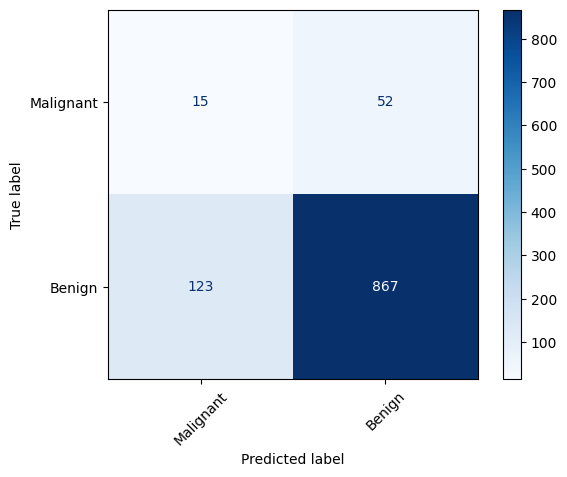

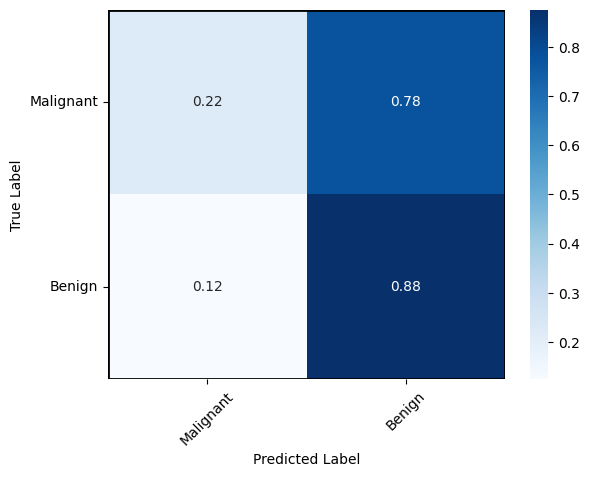

              precision    recall  f1-score   support

   Malignant       0.11      0.22      0.15        67
      Benign       0.94      0.88      0.91       990

    accuracy                           0.83      1057
   macro avg       0.53      0.55      0.53      1057
weighted avg       0.89      0.83      0.86      1057



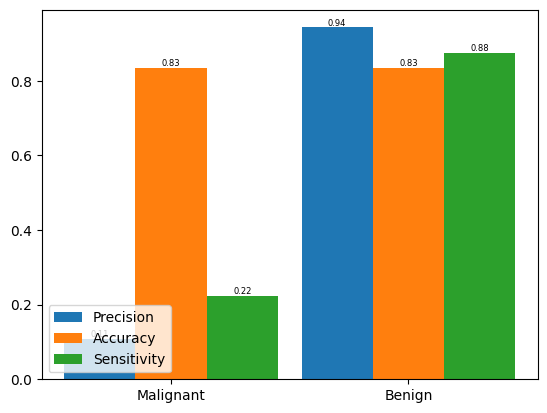

In [1]:
get_metrics(X_test, y_test, densenet_model)

In [11]:
densenet_model.save_weights('improved_densenet201.h5')